In [4]:
pip install ucimlrepo

In [5]:
# ==========================================
# 1. SETUP, IMPORTS & FOLDERS
# ==========================================
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Library Machine Learning
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import   accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Membuat folder untuk menyimpan hasil (Artifacts)
os.makedirs('models', exist_ok=True)
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [6]:

# ==========================================
# 2. DATA LOADING & CLEANING (ID: 519)
# ==========================================
print("Sedang mengambil dataset Heart Failure dari UCI Repository...")
# Menggunakan ID 519 sesuai laporan Heart Failure
dataset_repo = fetch_ucirepo(id=519)

# Mengambil fitur dan target
X_raw = dataset_repo.data.features
y_raw = dataset_repo.data.targets

# Menggabungkan Fitur dan Target menjadi satu DataFrame
raw_dataset = pd.concat([X_raw, y_raw], axis=1)

# Simpan ke file
raw_dataset.to_csv('data/heart_failure_raw_data.csv', index=False)
print(f"Berhasil! Dataset: {X_raw.shape[0]} Baris, {X_raw.shape[1]} Fitur")

print("\n--- Proses Cleaning (Sesuai Laporan 5.1) ---")
# Cek Missing Values
missing_count = X_raw.isnull().sum().sum()
if missing_count > 0:
    print(f"Ditemukan {missing_count} missing values. Melakukan imputasi...")
    X_raw = X_raw.fillna(X_raw.mean())
else:
    print("Data sudah bersih (Tidak ada missing values).")

# Menampilkan data awal
print("\n[Tabel] 5 Baris Pertama Data:")
print(X_raw.head())


Sedang mengambil dataset Heart Failure dari UCI Repository...
Berhasil! Dataset: 299 Baris, 12 Fitur

--- Proses Cleaning (Sesuai Laporan 5.1) ---
Data sudah bersih (Tidak ada missing values).

[Tabel] 5 Baris Pertama Data:
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  21000

In [7]:

# ==========================================
# 3. FEATURE ENGINEERING & TRANSFORMATION
# ==========================================
# Encoding Target (DEATH_EVENT)
le = LabelEncoder()
y = le.fit_transform(y_raw.values.ravel())
class_names = le.classes_

# Feature Selection
print("\nMelakukan Seleksi Fitur...")
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_raw, y)
selected_features = X_raw.columns[selector.get_support()]
X_final = pd.DataFrame(X_selected, columns=selected_features)

print(f"Fitur Terpilih: {list(selected_features)}")

# Scaling
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_final)
X_scaled = pd.DataFrame(X_scaled_array, columns=selected_features)

# Simpan scaler
joblib.dump(scaler, 'models/scaler.pkl')


Melakukan Seleksi Fitur...
Fitur Terpilih: ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']


['models/scaler.pkl']

In [8]:

# ==========================================
# 4. DATA SPLITTING & BALANCING
# ==========================================
# Split: 80% Train, 20% Test (Sesuai Laporan 5.4)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# Menghitung Class Weights (Sesuai kode referensi Anda)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weights[i] for i in range(len(weights))}
print(f"✅ Data Splitting Selesai. Class Weights: {class_weight_dict}")


✅ Data Splitting Selesai. Class Weights: {0: np.float64(0.7376543209876543), 1: np.float64(1.551948051948052)}


In [9]:
# ==========================================
# 5. MODELING (WAJIB 3 MODEL)
# ==========================================

#MODEL 1: Baseline (Logistic Regression)
print("\nTraining Model 1: Logistic Regression...")
start_time_lr = time.time()
model_baseline = LogisticRegression(random_state=42, class_weight='balanced')
model_baseline.fit(X_train, y_train)
training_time_lr = time.time() - start_time_lr
joblib.dump(model_baseline, 'models/model_baseline.pkl')

#MODEL 2: Advanced (Random Forest)
print("Training Model 2: Random Forest...")
start_time_rf = time.time()
model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
model_rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time_rf
joblib.dump(model_rf, 'models/model_advanced.pkl')

#MODEL 3: Deep Learning
print("Training Model 3: Deep Learning (MLP)...")
#
model_dl = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output probabilitas untuk binary classification
])

model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time_dl = time.time()
history = model_dl.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict, # Sangat baik untuk menangani imbalance data
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

training_time_dl = time.time() - start_time_dl
model_dl.save('models/model_heart_failure_dl.keras')

# Pastikan variabel print di bawah ini benar urutannya
print("-" * 30)
print(f"✅ Training LR Selesai : {training_time_lr:.4f} detik")
print(f"✅ Training RF Selesai : {training_time_rf:.4f} detik")
print(f"✅ Training DL Selesai : {training_time_dl:.4f} detik")
print("-" * 30)


Training Model 1: Logistic Regression...
Training Model 2: Random Forest...
Training Model 3: Deep Learning (MLP)...
------------------------------
✅ Training LR Selesai : 0.0451 detik
✅ Training RF Selesai : 1.0197 detik
✅ Training DL Selesai : 11.9513 detik
------------------------------


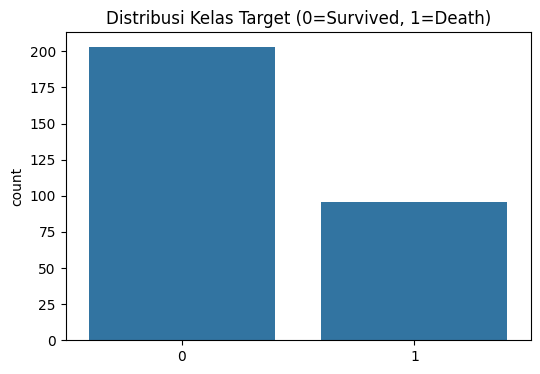

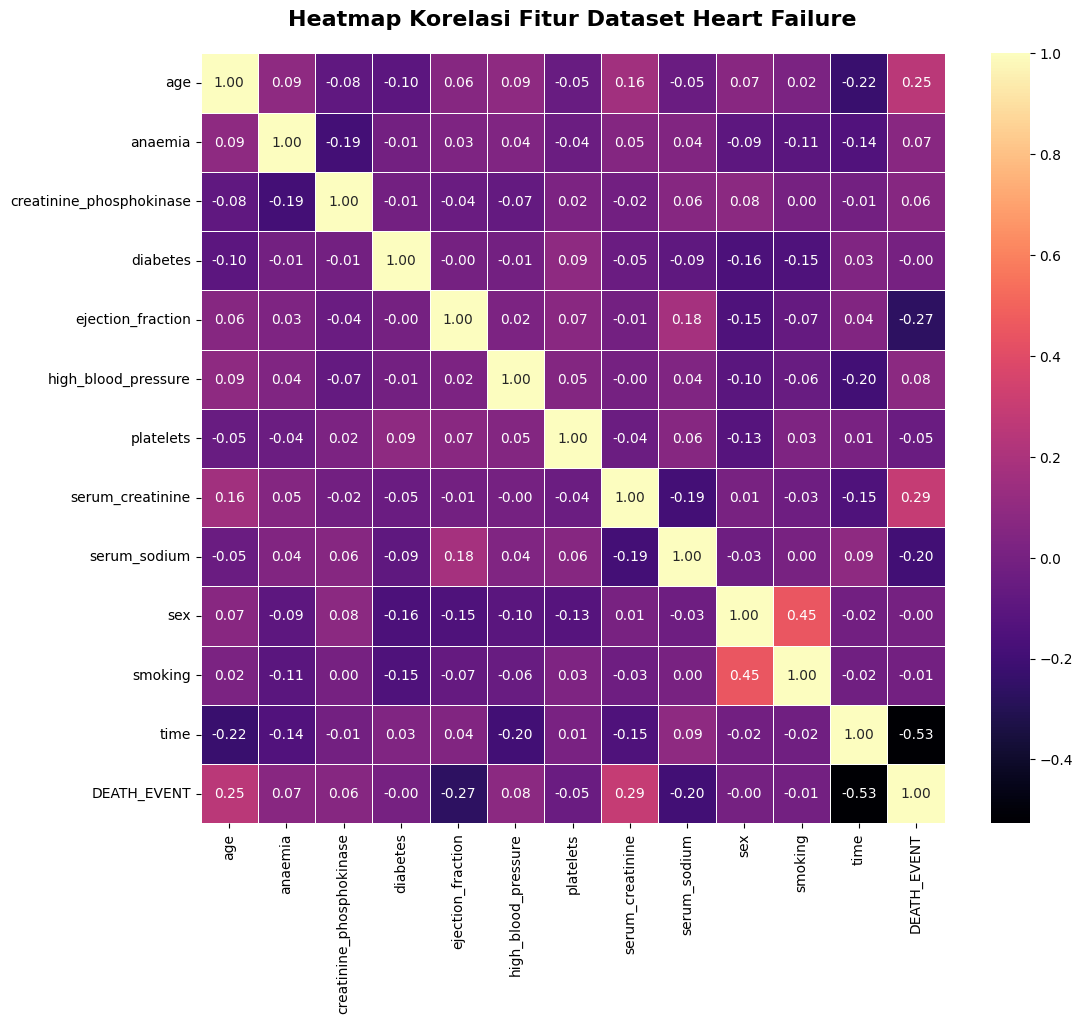

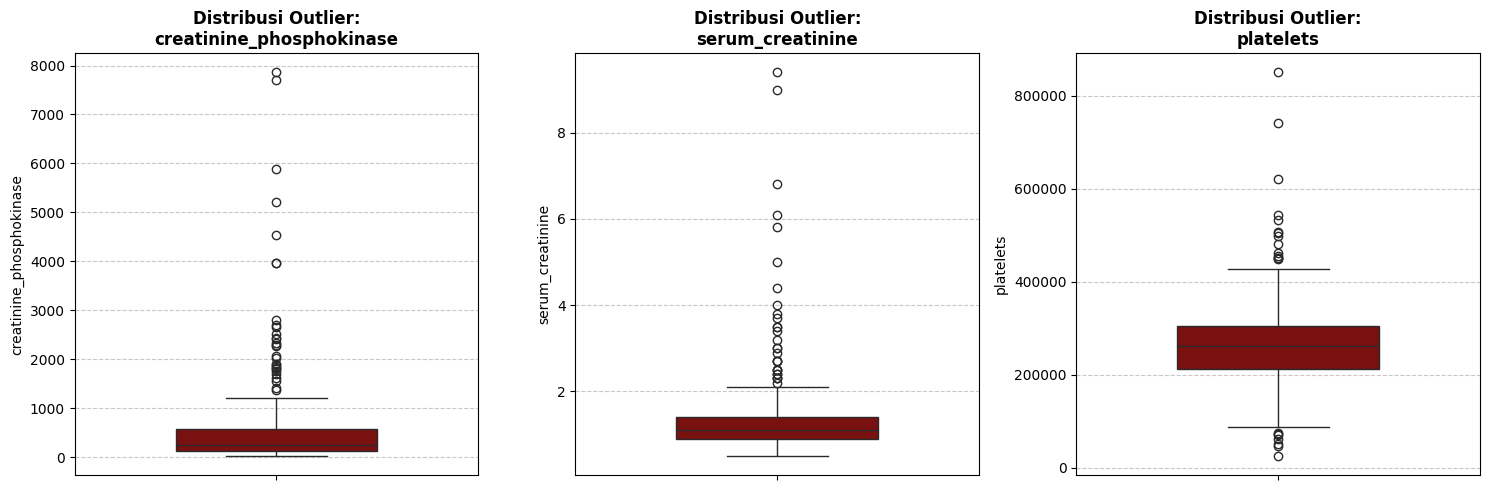

✅ Visualisasi outlier berhasil disimpan di folder images/.

 Evaluasi Model: Baseline (LogReg)...
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.75      0.63      0.69        19

    accuracy                           0.82        60
   macro avg       0.80      0.77      0.78        60
weighted avg       0.81      0.82      0.81        60


 Evaluasi Model: Advanced (RF)...
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60


 Evaluasi Model: Deep Learning (MLP)...
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        41
           1       0.62      0.79      0.70        19

    accu

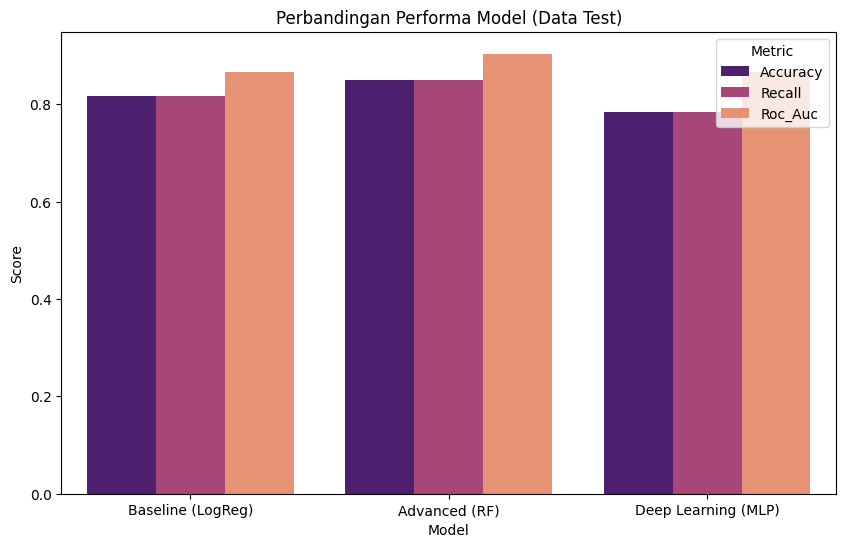

In [10]:

# ==========================================
# 6. VISUALIZATION & EVALUATION
# ==========================================
# 1. Distribusi Kelas
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribusi Kelas Target (0=Survived, 1=Death)')
plt.savefig('images/viz1_class_distribution.png')
# 2 heatmap

df_corr = X_raw.copy()
df_corr['DEATH_EVENT'] = y
plt.figure(figsize=(12, 10))

correlation_matrix = df_corr.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma', linewidths=0.5)

plt.title('Heatmap Korelasi Fitur Dataset Heart Failure', fontsize=16, fontweight='bold', pad=20)
plt.savefig('images/viz2_correlation_heatmap.png')
plt.show()

#3 boxplot
# Pilih fitur numerik yang biasanya memiliki outlier di dataset ini
outlier_features = ['creatinine_phosphokinase', 'serum_creatinine', 'platelets']

plt.figure(figsize=(15, 5))

for i, col in enumerate(outlier_features):
    plt.subplot(1, 3, i + 1)
    # Menggunakan palet 'magma' agar senada dengan diagram perbandingan model Anda
    sns.boxplot(y=X_raw[col], color='#8b0000', width=0.5)
    plt.title(f'Distribusi Outlier:\n{col}', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('images/viz3_outlier_detection.png')
plt.show()

print("✅ Visualisasi outlier berhasil disimpan di folder images/.")

# 5. Evaluasi Perbandingan
models_dict = {
    'Baseline (LogReg)': model_baseline,
    'Advanced (RF)': model_rf,
    'Deep Learning (MLP)': model_dl
}

final_metrics = []
for name, model in models_dict.items():
    print(f"\n Evaluasi Model: {name}...")

    # 2. Lakukan Prediksi
    if name == 'Deep Learning (MLP)':
        # Output DL adalah probabilitas
        y_prob = model.predict(X_test, verbose=0)
        y_pred = (y_prob > 0.5).astype(int).flatten()
    else:
        # Output Sklearn langsung kelas 0/1
        y_prob = model.predict_proba(X_test)[:, 1] # Get probabilities for ROC AUC
        y_pred = model.predict(X_test)

    # 3. Hitung Metrik
    acc = accuracy_score(y_test, y_pred)

    # Gunakan average='weighted' agar F1-Score lebih adil
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) # Menghitung ROC AUC

    final_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Recall': rec,
        'Roc_Auc': roc_auc
    })

    # Print Laporan Detail
    print(classification_report(y_test, y_pred, zero_division=0))

# Tampilkan Tabel Hasil
df_metrics = pd.DataFrame(final_metrics)
print("\n=== TABEL PERBANDINGAN AKHIR ===")
print(df_metrics.to_string(index=False))

# Simpan Visualisasi Perbandingan
plt.figure(figsize=(10, 6))
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="magma")
plt.title("Perbandingan Performa Model (Data Test)")
plt.savefig('images/viz5_model_comparison.png')


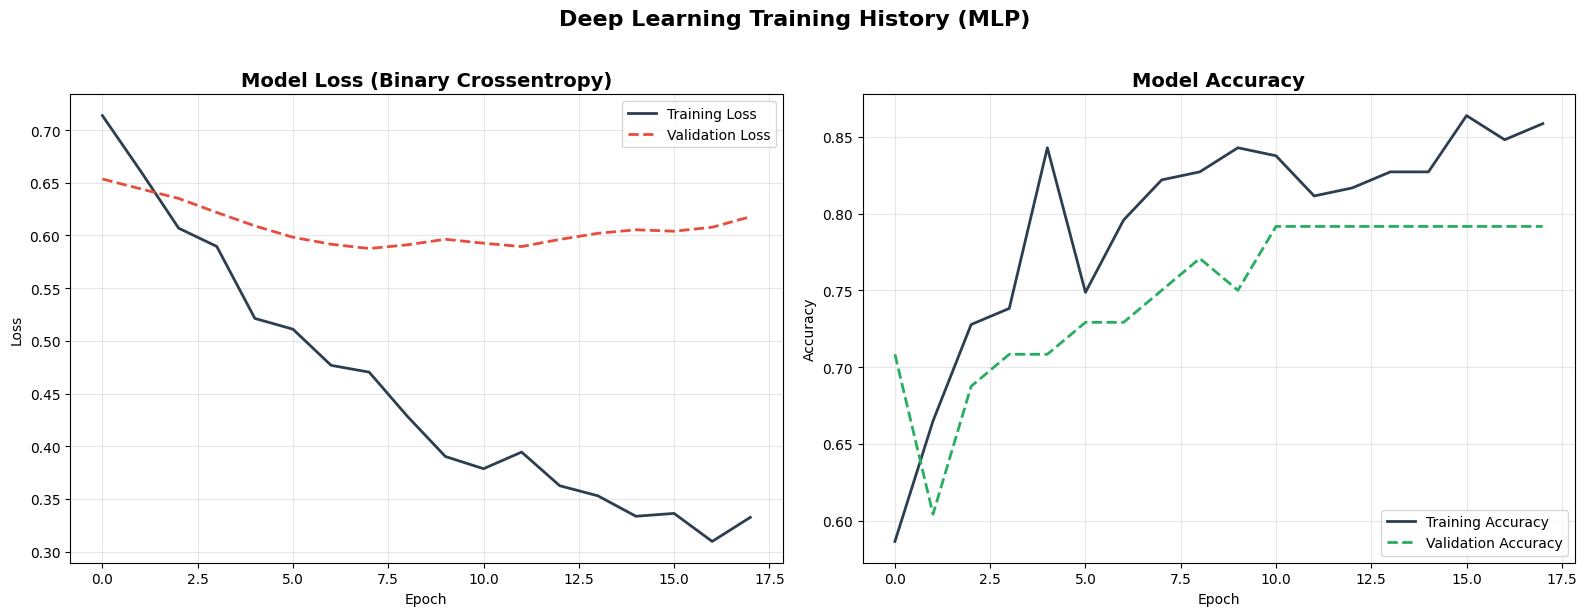

✅ Visualisasi Training History (Loss & Accuracy) berhasil disimpan.


In [11]:
# ==========================================
# VISUALISASI TRAINING HISTORY (LOSS & ACCURACY)
# ==========================================

# Set style visualisasi
plt.style.use('seaborn-v0_8-muted') # atau 'ggplot'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- 1. Grafik Training & Validation Loss ---
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2c3e50')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c', linestyle='--')
ax1.set_title('Model Loss (Binary Crossentropy)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- 2. Grafik Training & Validation Accuracy ---
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2c3e50')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#27ae60', linestyle='--')
ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.suptitle('Deep Learning Training History (MLP)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Simpan hasil visualisasi
plt.savefig('images/viz4_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi Training History (Loss & Accuracy) berhasil disimpan.")

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189 (114.02 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,460 (76.02 KB)

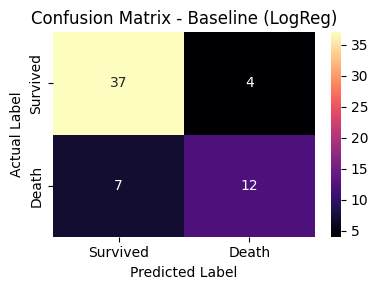

Confusion Matrix Baseline (LogReg) disimpan di: images/confusion_matrix_Baseline_LogReg.png


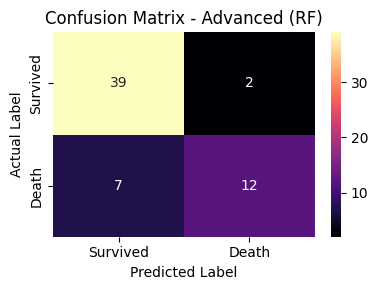

Confusion Matrix Advanced (RF) disimpan di: images/confusion_matrix_Advanced_RF.png


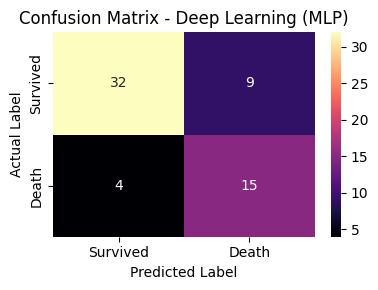

Confusion Matrix Deep Learning (MLP) disimpan di: images/confusion_matrix_Deep_Learning_MLP.png


In [14]:
from sklearn.metrics import confusion_matrix

# ==========================================
# VISUALISASI CONFUSION MATRIX FINAL
# ==========================================

for name, model in models_dict.items():
    # Prediksi
    if name == 'Deep Learning (MLP)':
        y_prob = model.predict(X_test, verbose=0)
        y_pred = (y_prob > 0.5).astype(int).flatten()
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='magma',
        xticklabels=['Survived', 'Death'],
        yticklabels=['Survived', 'Death']
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()

    filename = f'images/confusion_matrix_{name.replace(" ", "_").replace("(", "").replace(")", "")}.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"Confusion Matrix {name} disimpan di: {filename}")
